In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


In [2]:
def load_csv_folder(folder_path):
    all_files = glob(os.path.join(folder_path, "*.csv"))
    
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)
    
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df


In [3]:
base_path = "raw"

enrollment_df = load_csv_folder(
    os.path.join(base_path, "api_data_aadhar_enrolment")
)

demographic_df = load_csv_folder(
    os.path.join(base_path, "api_data_aadhar_demographic")
)

biometric_df = load_csv_folder(
    os.path.join(base_path, "api_data_aadhar_biometric")
)


In [4]:
for name, df in {
    "Enrollment": enrollment_df,
    "Demographic": demographic_df,
    "Biometric": biometric_df
}.items():
    print(f"\n{name}")
    print(df.shape)
    print(df.dtypes)
    print(df.head(2))



Enrollment
(1006029, 7)
date              object
state             object
district          object
pincode            int64
age_0_5            int64
age_5_17           int64
age_18_greater     int64
dtype: object
         date      state          district  pincode  age_0_5  age_5_17  \
0  02-03-2025  Meghalaya  East Khasi Hills   793121       11        61   
1  09-03-2025  Karnataka   Bengaluru Urban   560043       14        33   

   age_18_greater  
0              37  
1              39  

Demographic
(2071700, 6)
date             object
state            object
district         object
pincode           int64
demo_age_5_17     int64
demo_age_17_      int64
dtype: object
         date           state   district  pincode  demo_age_5_17  demo_age_17_
0  01-03-2025   Uttar Pradesh  Gorakhpur   273213             49           529
1  01-03-2025  Andhra Pradesh   Chittoor   517132             22           375

Biometric
(1861108, 6)
date            object
state           object
district    

In [5]:
for df in [enrollment_df, demographic_df, biometric_df]:
    df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")
    df["month"] = df["date"].dt.to_period("M")


In [6]:
for df in [enrollment_df, demographic_df, biometric_df]:
    df.drop(columns=["pincode"], inplace=True)


In [7]:
def remove_aggregate_rows(df):
    return df[
        (df["state"].astype(str) != "100000") &
        (df["district"].astype(str) != "100000")
    ]


In [8]:

enroll_agg = (
    enrollment_df
    .groupby(["state", "district", "month"], as_index=False)
    .agg({
        "age_0_5": "sum",
        "age_5_17": "sum",
        "age_18_greater": "sum"
    })
)

enroll_agg["total_enrollment"] = (
    enroll_agg["age_0_5"] +
    enroll_agg["age_5_17"] +
    enroll_agg["age_18_greater"]
)


In [9]:
demo_agg = (
    demographic_df
    .groupby(["state", "district", "month"], as_index=False)
    .agg({
        
        "demo_age_5_17": "sum",
        "demo_age_17_": "sum"
    })
)

demo_agg["total_demo_updates"] = (
    demo_agg["demo_age_5_17"] +
    demo_agg["demo_age_17_"]
)



In [10]:
bio_agg = (
    biometric_df
    .groupby(["state", "district", "month"], as_index=False)
    .agg({
        
        "bio_age_5_17": "sum",
        "bio_age_17_": "sum"
    })
)

bio_agg["total_bio_updates"] = (
    bio_agg["bio_age_5_17"] +
    bio_agg["bio_age_17_"]
)



In [11]:
enroll_agg = remove_aggregate_rows(enroll_agg)
demo_agg   = remove_aggregate_rows(demo_agg)
bio_agg    = remove_aggregate_rows(bio_agg)


In [12]:
merged_df = enroll_agg.merge(
    demo_agg[["state", "district", "month", "total_demo_updates"]],
    on=["state", "district", "month"],
    how="left"
).merge(
    bio_agg[["state", "district", "month", "total_bio_updates"]],
    on=["state", "district", "month"],
    how="left"
)


In [13]:
enroll_agg["state"].unique()[:5]


array(['Andaman & Nicobar Islands', 'Andaman and Nicobar Islands',
       'Andhra Pradesh', 'Arunachal Pradesh', 'Assam'], dtype=object)

In [14]:
merged_df.isna().sum()


state                   0
district                0
month                   0
age_0_5                 0
age_5_17                0
age_18_greater          0
total_enrollment        0
total_demo_updates    683
total_bio_updates     104
dtype: int64

In [15]:
merged_df["total_demo_updates"] = merged_df["total_demo_updates"].fillna(0)
merged_df["total_bio_updates"] = merged_df["total_bio_updates"].fillna(0)


In [16]:
merged_df.shape
merged_df.describe()


,age_0_5,age_5_17,age_18_greater,total_enrollment,total_demo_updates,total_bio_updates
count,5058.000000,5058.000000,5058.000000,5058.000000,5058.000000,5058.000000
mean,701.258403,340.131079,33.241597,1074.631079,7113.015817,8281.575129
std,861.630903,582.984064,103.906728,1342.327172,10930.889876,10024.366319
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,102.250000,24.000000,0.000000,167.250000,249.250000,864.250000
50%,425.000000,113.000000,7.000000,620.500000,3292.500000,4909.000000
75%,983.250000,382.750000,26.000000,1496.500000,9008.750000,12076.000000
max,12270.000000,6314.000000,2404.000000,13877.000000,133650.000000,89018.000000


In [17]:
merged_df[merged_df["total_demo_updates"] == 0].head()


,state,district,month,age_0_5,age_5_17,age_18_greater,total_enrollment,total_demo_updates,total_bio_updates
4,Andaman & Nicobar Islands,Nicobars,2025-09,1,0,0,1,0.0,1.0
165,Andhra Pradesh,Spsr Nellore,2025-03,43,44,29,116,0.0,0.0
166,Andhra Pradesh,Spsr Nellore,2025-06,742,405,201,1348,0.0,0.0
167,Andhra Pradesh,Spsr Nellore,2025-07,382,264,73,719,0.0,0.0
184,Andhra Pradesh,Visakhapatanam,2025-06,186,28,12,226,0.0,0.0


In [18]:
merged_df["demo_update_rate"] = (
    merged_df["total_demo_updates"] / merged_df["total_enrollment"]
)

merged_df["bio_update_rate"] = (
    merged_df["total_bio_updates"] / merged_df["total_enrollment"]
)


In [19]:
merged_df["enrollment_growth_proxy"] = (
    merged_df["age_0_5"] + merged_df["age_5_17"]
)


In [20]:
merged_df.groupby("month")[["demo_update_rate", "bio_update_rate"]].mean()


,demo_update_rate,bio_update_rate
month,,
2025-03,181.138371,121.009800
2025-04,7.070445,34.907959
2025-05,4.921201,34.616427
2025-06,3.605920,25.252833
2025-07,2.394626,15.231016
2025-09,5.810463,4.877947
2025-10,7.113974,6.626221
2025-11,10.227547,7.930567
2025-12,17.266045,13.270170


In [23]:
features = [
    "demo_update_rate",
    "bio_update_rate",
    "total_enrollment"
]

# Apply Z-score standardization per state
merged_df[features] = merged_df.groupby("state")[features].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Optional: Fill NaNs that occur if a state has only 1 row (std = 0)
merged_df[features] = merged_df[features].fillna(0)

In [24]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=200,
    contamination=0.03,
    random_state=42
)

merged_df["anomaly_score"] = model.fit_predict(merged_df[features])


In [25]:
# Create a dataframe of just the anomalies
anomalies = merged_df[merged_df["anomaly_score"] == -1]

# Check how many anomalies were found
print(f"Total anomalies detected: {len(anomalies)}")

# Look at the first few anomalies
anomalies.head()

Total anomalies detected: 152


,state,district,month,age_0_5,age_5_17,age_18_greater,total_enrollment,total_demo_updates,total_bio_updates,demo_update_rate,bio_update_rate,enrollment_growth_proxy,anomaly_score
4,Andaman & Nicobar Islands,Nicobars,2025-09,1,0,0,-1.503032,0.0,1.0,-1.546638,-2.078197,1,-1
12,Andaman and Nicobar Islands,Nicobar,2025-12,5,1,0,-1.520298,75.0,265.0,0.378861,2.584654,6,-1
24,Andhra Pradesh,Adilabad,2025-12,92,16,0,-0.760053,7291.0,6390.0,4.755917,4.304776,108,-1
87,Andhra Pradesh,K.v. Rangareddy,2025-11,1,0,0,-0.898854,40.0,72.0,2.300482,5.474776,1,-1
104,Andhra Pradesh,Khammam,2025-12,101,14,0,-0.750973,8203.0,4108.0,5.096989,2.167330,115,-1


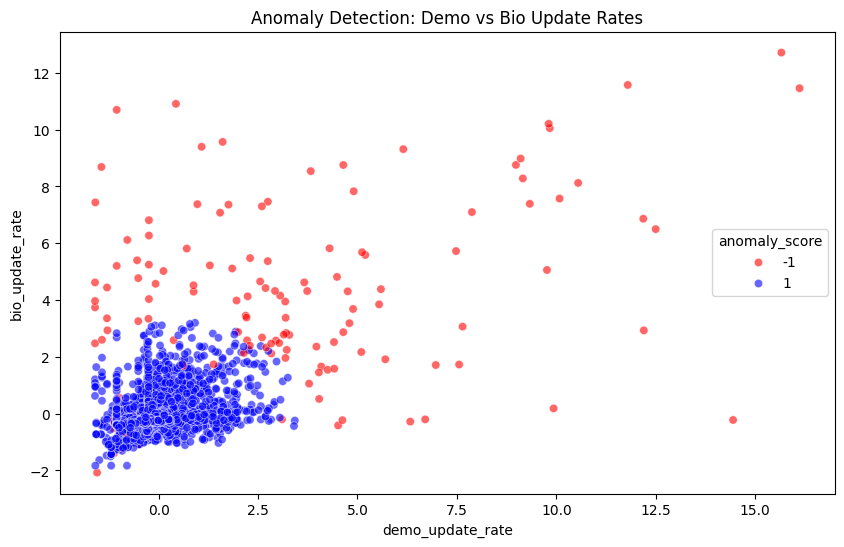

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_df, 
    x="demo_update_rate", 
    y="bio_update_rate", 
    hue="anomaly_score", 
    palette={1: "blue", -1: "red"},
    alpha=0.6
)
plt.title("Anomaly Detection: Demo vs Bio Update Rates")
plt.show()

In [27]:
# Filter for just the anomalies
anomalies = merged_df[merged_df["anomaly_score"] == -1]

# Sort by the most extreme demo update rates to see the worst cases
top_anomalies = anomalies.sort_values(by="demo_update_rate", ascending=False)

# Display the State, Month, and the rates to identify patterns
print(top_anomalies[["state", "month", "demo_update_rate", "bio_update_rate"]].head(10))

               state    month  demo_update_rate  bio_update_rate
2777     Maharashtra  2025-03         16.115990        11.457669
4440   Uttar Pradesh  2025-03         15.658945        12.712244
1930       Karnataka  2025-09         14.444560        -0.225514
1738       Jharkhand  2025-03         12.498878         6.495109
2235  Madhya Pradesh  2025-03         12.200040         2.929915
1408         Gujarat  2025-03         12.186355         6.860869
4350   Uttar Pradesh  2025-03         11.796417        11.572210
502            Assam  2025-03         10.549035         8.121229
1437         Haryana  2025-03         10.081347         7.571899
3688       Rajasthan  2025-12          9.931590         0.180762
